In [ ]:
from typing import List, Tuple, Union
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

### Preprocesador de Datos

In [ ]:
class DataProcessor:
    def __init__(self, delimiter=";", date_format="%Y/%m/%d %H:%M:%S"):
        self.delimiter = delimiter
        self.date_format = date_format

    def read_file(self, file_path, skiprows=None):
        """Reads a CSV file with a specified delimiter, optionally skipping non-data header lines."""
        try:
            df = pd.read_csv(file_path, delimiter=self.delimiter, skiprows=skiprows)
            return df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return None

    def clean_and_reorder_columns(self, df):
        """Cleans columns by removing 'AXI' if it exists, reordering columns, and renaming them."""
        if "AXI" in df.columns:
            df = df.drop("AXI", axis=1)
        date_col = df.columns[0]
        other_cols = [col for col in df.columns if col != date_col]
        df = df[[date_col] + other_cols]
        df.columns = ["Fecha"] + [df.columns[i] for i in range(1, len(df.columns))]
        return df

    def convert_to_float_and_date_time(self, df):
        """Converts columns to the appropriate data types."""
        for col in df.columns[1:]:
            df[col] = df[col].astype(str).str.replace(",", ".").astype(float)
        df["Fecha"] = pd.to_datetime(df["Fecha"], format=self.date_format, errors="coerce")
        return df

    def process_file(self, file_path):
        """Processes a single file by reading, cleaning, and converting data types."""
        df = self.read_file(file_path, skiprows=2)  # Skiprows=2 para preprocesamiento
        if df is not None:
            df = self.clean_and_reorder_columns(df)
            df = self.convert_to_float_and_date_time(df)
        return df

### Calculo de velocidad nominal

In [ ]:
# Funciones auxiliares
def calculate_nominal_speed_and_max_values(df, speed_col="KPH", date_col="Fecha", threshold=3):
    df["speed_diff"] = df[speed_col].diff().abs()
    stable_region = df[(df[speed_col] > 0) & (df["speed_diff"] <= threshold)]
    nominal_speed = stable_region[speed_col].max()
    columns_of_interest = [col for col in stable_region.columns if col not in [date_col, "speed_diff"]]
    max_values = {col: stable_region[col].max() for col in columns_of_interest}
    df.drop(columns=["speed_diff"], inplace=True)
    return nominal_speed, max_values

def normalize_dataframe(df, max_values):
    """Normalize specified columns in the dataframe using provided maximum values."""
    for column, max_val in max_values.items():
        if max_val > 0:
            df[column] = df[column] / max_val
        else:
            raise ValueError(f"Max value for {column} is non-positive, cannot normalize.")
    return df

# Pipeline que calcula los residuos a través de una regresión lineal

In [ ]:
class DataResidualsProcessor:
    """Clase para procesar datos, ajustar modelos y calcular residuos."""

    def __init__(self, degree: int = 3, speed_col: str = 'KPH'):
        """
        Inicializa el procesador.

        Parámetros:
        - degree: Grado del polinomio para el modelo.
        - speed_col: Nombre de la columna de velocidad en el DataFrame.
        """
        self.degree = degree
        self.speed_col = speed_col
        self.poly = PolynomialFeatures(degree=self.degree)
        self.models = {}
        self.displacement_cols = None
        self.processor = DataProcessor(delimiter=";")  # Sin cambios
        self.df = None

    def _load_and_preprocess(self, ruta_archivo: str) -> pd.DataFrame:
        """Carga y preprocesa un archivo."""
        df = self.processor.process_file(ruta_archivo)  # Usa el flujo original con skiprows=2
        if df is None:
            raise ValueError(f"No se pudo procesar el archivo {ruta_archivo}.")
        nominal_speed, max_values = calculate_nominal_speed_and_max_values(df, speed_col=self.speed_col)
        df_normalized = normalize_dataframe(df, max_values)
        return df_normalized

    def _extract_variable_columns(self, nombre_archivo: str) -> List[str]:
        """Extrae columnas variables del nombre del archivo."""
        match = re.search(r'Desbln([A-Z]+)\.csv$', nombre_archivo)
        if match:
            texto_mayusculas = match.group(1)
            columnas = [texto_mayusculas[i:i+3] for i in range(0, len(texto_mayusculas), 3)]
            return columnas
        return []

    def _get_displacement_cols(self, ruta_archivo: str, df: pd.DataFrame) -> List[str]:
        """Obtiene las columnas de desplazamiento basadas en el nombre del archivo."""
        nombre_archivo = ruta_archivo.split('/')[-1]
        if nombre_archivo.endswith('Desln.csv'):
            columnas = [col for col in df.columns if col not in ['Fecha', self.speed_col]]
        else:
            columnas = self._extract_variable_columns(nombre_archivo)
        if not columnas:
            raise ValueError(f"No se encontraron columnas de desplazamiento válidas en {nombre_archivo}")
        return columnas

    def fit(self, df: pd.DataFrame = None, ruta_archivo: str = None, is_preprocessed: bool = False) -> 'DataResidualsProcessor':
        """Ajusta modelos polinómicos para las columnas de desplazamiento."""
        if df is None:
            if ruta_archivo is None:
                raise ValueError("Se debe proporcionar un DataFrame o una ruta de archivo.")
            if is_preprocessed:
                # Para archivos preprocesados, usamos pd.read_csv directamente con delimitador ","
                try:
                    df = pd.read_csv(ruta_archivo, delimiter=",", skiprows=None)
                    print(f"Columnas leídas desde {ruta_archivo}: {df.columns.tolist()}")  # Depuración
                except Exception as e:
                    raise ValueError(f"No se pudo leer el archivo preprocesado {ruta_archivo}: {e}")
            else:
                df = self._load_and_preprocess(ruta_archivo)

        if df is None:
            raise ValueError(f"No se pudo leer o procesar el archivo {ruta_archivo}.")

        self.df = df
        displacement_cols = self._get_displacement_cols(ruta_archivo, df)
        kph = df[self.speed_col].values.reshape(-1, 1)
        X_poly = self.poly.fit_transform(kph)

        for col in displacement_cols:
            if col not in df.columns:
                raise ValueError(f"La columna {col} no está en el DataFrame.")
            y = df[col].values
            model = LinearRegression()
            model.fit(X_poly, y)
            self.models[col] = model

        self.displacement_cols = displacement_cols
        return self

    def calculate_residuals(self, ruta_archivo: str = None) -> Tuple[np.ndarray, List[str], np.ndarray, np.ndarray, np.ndarray]:
        """Calcula residuos, predicciones y datos originales."""
        if not self.models:
            raise RuntimeError("Debes llamar a fit() antes de calculate_residuals().")
c
        if ruta_archivo is not None:
            try:
                df = pd.read_csv(ruta_archivo, delimiter=",", skiprows=None)  # Para preprocesados
                print(f"Columnas leídas desde {ruta_archivo}: {df.columns.tolist()}")  # Depuración
            except Exception as e:
                raise ValueError(f"No se pudo leer el archivo preprocesado {ruta_archivo}: {e}")
        elif self.df is not None:
            df = self.df
        else:
            raise ValueError("No hay datos disponibles. Proporciona una ruta o llama a fit() primero.")

        if df is None:
            raise ValueError(f"No se pudo leer el archivo {ruta_archivo} en calculate_residuals.")

        kph = df[self.speed_col].values.reshape(-1, 1)
        X_poly = self.poly.transform(kph)

        residuos = []
        predicciones = []
        datos_originales = []

        for col in self.displacement_cols:
            y = df[col].values
            y_pred = self.models[col].predict(X_poly)
            residuo = y - y_pred
            residuos.append(residuo)
            predicciones.append(y_pred)
            datos_originales.append(y)

        return (
            np.column_stack(residuos),
            self.displacement_cols,
            kph,
            np.column_stack(datos_originales),
            np.column_stack(predicciones)
        )

def obtener_residuos(file_paths: List[str], is_preprocessed: bool = False) -> Tuple[List, List]:
    """Obtiene residuos y columnas de una lista de archivos usando la clase."""
    processor = DataResidualsProcessor(degree=3)
    todos_residuos = []
    todas_columnas = []

    for ruta_archivo in file_paths:
        processor.fit(ruta_archivo=ruta_archivo, is_preprocessed=is_preprocessed)
        residuos, columnas, _, _, _ = processor.calculate_residuals()
        todos_residuos.append(residuos)
        todas_columnas.append(columnas)

    return todos_residuos, todas_columnas

### Obtención de las rutas a través de Glob

In [ ]:
import glob

In [ ]:
def get_routes(imbalance_folder: str, misalignment_folder: str = None) -> List[str]:
  imbalance_path = glob.glob(f"{imbalance_folder}/*.csv")
  if misalignment_folder is None:
    return imbalance_path
  else:
    misalignment_path = glob.glob(f"{misalignment_folder}/*.csv")
    return imbalance_path + misalignment_path

In [ ]:
# Obtención de las rutas de los archivos .csv
imbalance_folder = "/content/drive/MyDrive/desbalanceo/normalize_data"
misalignment_folder = "/content/drive/MyDrive/desalineacion/normalize_data"
file_paths = get_routes(imbalance_folder, misalignment_folder)
file_paths

['/content/drive/MyDrive/desbalanceo/normalize_data/5_paradaDesblnCILCIP.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/1_arranqueParadaDesblnCILCIP.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/2_arranqueParadaDesblnCILCIP.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/3_arranqueParadaDesblnCSLCSPCTP.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/4_arranqueParadaDesblnCSLCSPCTP.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/6_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/7_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/8_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/9_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/10_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/11_paradaDesblnCSLCSPCTP.csv',
 '/content/drive/MyDrive/desbalanceo/normalize_data/12_paradaDesblnCSLCSPCTP.csv',
 '/co

### Ejemplo para una única ruta con un paso y un .fit en el pipeline

In [ ]:
processor = DataResidualsProcessor(degree=3)
processor.fit(ruta_archivo=file_paths[0], is_preprocessed = True)  # Determina columnas automáticamente
residuos, columnas, kph, originales, preds = processor.calculate_residuals(ruta_archivo = file_paths[0])
print("Residuos:", residuos)
print("Columnas:", columnas)

Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/5_paradaDesblnCILCIP.csv: ['Fecha', 'KPH', 'CIP', 'CIL', 'CTP']
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/5_paradaDesblnCILCIP.csv: ['Fecha', 'KPH', 'CIP', 'CIL', 'CTP']
Residuos: [[ 2.76949304e-03  4.14557397e-03]
 [ 1.37672539e-02  9.37620878e-03]
 [ 1.54386232e-02 -2.70191489e-05]
 [-3.41642783e-03  1.35280999e-02]
 [ 5.69481669e-03  8.82979273e-03]
 [ 1.08319961e-02 -9.68257186e-03]
 [ 7.09279904e-03  2.78816725e-03]
 [-2.78833322e-03  4.69885369e-03]
 [ 6.56339744e-03  1.02111670e-02]
 [ 1.33193879e-02 -1.31544463e-03]
 [ 2.21922386e-03  3.09512518e-03]
 [-7.52295860e-03  1.23851583e-02]
 [ 7.65154052e-03 -7.55719300e-05]
 [ 1.51571759e-02 -5.07419234e-03]
 [ 1.83736947e-02  1.30392548e-02]
 [ 2.08542342e-03  1.60909960e-02]
 [ 1.35104838e-02  1.14940595e-02]
 [ 4.73198573e-03 -5.03459267e-03]
 [ 2.10605726e-02  6.31311453e-03]
 [ 9.92557260e-03 -7.98960850e-03]
 [ 1.76537983e-03 

### Calculo de los residuos para entrenamiento

In [ ]:
residuos, columnas = obtener_residuos(file_paths, is_preprocessed=True)
print("Todos los residuos:", residuos)
print("Todas las columnas:", columnas)

Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/5_paradaDesblnCILCIP.csv: ['Fecha', 'KPH', 'CIP', 'CIL', 'CTP']
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/1_arranqueParadaDesblnCILCIP.csv: ['Fecha', 'KPH', 'CIP', 'CIL', 'CTP', 'CTL']
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/2_arranqueParadaDesblnCILCIP.csv: ['Fecha', 'KPH', 'CIP', 'CIL', 'CTP', 'CTL']
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/3_arranqueParadaDesblnCSLCSPCTP.csv: ['Fecha', 'KPH', 'CSP', 'CSL', 'CTP', 'CTL']
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/4_arranqueParadaDesblnCSLCSPCTP.csv: ['Fecha', 'KPH', 'CSP', 'CSL', 'CTP', 'CTL']
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/6_paradaDesblnCSPCSL.csv: ['Fecha', 'KPH', 'CSP', 'CSL', 'CIP', 'CIL', 'CTP', 'CTL']
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/7_paradaDesblnCSPCSL.csv:

### Construcción de pipeline de entrenamiento de mezclas gaussianas

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro, skew, kurtosis, boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.pipeline import Pipeline
import joblib

In [ ]:
class ResidualsAnalyzer:
    def __init__(self, fill_value=np.nan, scaler_type='robust', n_components=2, random_state=42, transform=None):
        self.fill_value = fill_value
        self.scaler_type = scaler_type
        self.n_components = n_components
        self.random_state = random_state
        self.transform = transform
        self.scaler = self._get_scaler()
        self.pca = None
        self.gmm = None
        self.residuos_igualados = None
        self.residuos_scaled = None
        self.residuos_pca = None

    def _get_scaler(self):
        if self.scaler_type == 'minmax':
            return MinMaxScaler()
        elif self.scaler_type == 'standard':
            return StandardScaler()
        elif self.scaler_type == 'robust':
            return RobustScaler()
        else:
            raise ValueError("scaler_type debe ser 'minmax', 'standard' o 'robust'")

    def rellenar_residuos(self, lista_residuos: List[np.ndarray], stack_mode='rows') -> np.ndarray:
        lista_residuos_2d = [r[:, np.newaxis] if r.ndim == 1 else r for r in lista_residuos]
        if stack_mode == 'columns':
            max_filas = max(residuos.shape[0] for residuos in lista_residuos_2d)
            residuos_igualados = []
            for residuos in lista_residuos_2d:
                n_filas, n_cols = residuos.shape
                if n_filas < max_filas:
                    residuos_rellenados = np.pad(residuos, ((0, max_filas - n_filas), (0, 0)),
                                                mode='constant', constant_values=self.fill_value)
                    residuos_igualados.append(residuos_rellenados)
                else:
                    residuos_igualados.append(residuos)
            return np.hstack(residuos_igualados)
        else:  # stack_mode='rows'
            max_columnas = max(residuos.shape[1] for residuos in lista_residuos_2d)
            residuos_igualados = []
            for residuos in lista_residuos_2d:
                n_filas, n_cols = residuos.shape
                if n_cols < max_columnas:
                    residuos_rellenados = np.pad(residuos, ((0, 0), (0, max_columnas - n_cols)),
                                                mode='constant', constant_values=self.fill_value)
                    residuos_igualados.append(residuos_rellenados)
                else:
                    residuos_igualados.append(residuos)
            return np.vstack(residuos_igualados)

    def _apply_transform(self, residuos: np.ndarray) -> np.ndarray:
        if self.transform == 'log':
            min_val = np.min(residuos)
            if min_val <= 0:
                residuos = residuos - min_val + 1e-6
            return np.log1p(residuos)
        elif self.transform == 'boxcox':
            min_val = np.min(residuos)
            if min_val <= 0:
                residuos = residuos - min_val + 1e-6
            transformed = np.zeros_like(residuos)
            for i in range(residuos.shape[1]):
                transformed[:, i], _ = boxcox(residuos[:, i] + 1e-6)  # Añadir pequeño offset
            return transformed
        return residuos

    def analyze_statistics(self, lista_residuos: Union[List[np.ndarray], np.ndarray]):
        if isinstance(lista_residuos, np.ndarray):
            residuos_apilados = lista_residuos
        else:
            residuos_apilados = self.rellenar_residuos(lista_residuos, stack_mode='rows')

        residuos_transformados = self._apply_transform(residuos_apilados)
        residuos_no_nan = np.nan_to_num(residuos_transformados, nan=0.0)

        stats = {
            'Media': np.mean(residuos_no_nan, axis=0),
            'Desv. Est.': np.std(residuos_no_nan, axis=0),
            'Asimetría': skew(residuos_no_nan, axis=0),
            'Curtosis': kurtosis(residuos_no_nan, axis=0)
        }
        print("Estadísticas de los residuos:")
        for key, value in stats.items():
            print(f"{key}: {value}")

        # Limitar tamaño de muestra para Shapiro y evitar warning
        sample_size = min(5000, residuos_no_nan.shape[0])
        indices = np.random.choice(residuos_no_nan.shape[0], sample_size, replace=False)
        for i in range(residuos_no_nan.shape[1]):
            stat, p = shapiro(residuos_no_nan[indices, i])
            print(f"Columna {i+1} - Shapiro (p-valor): {p:.4f} {'(Gaussiana)' if p > 0.05 else '(No Gaussiana)'}")

        plt.figure(figsize=(10, 6))
        for i in range(residuos_no_nan.shape[1]):
            plt.hist(residuos_no_nan[:, i], bins=30, alpha=0.5, label=f'Columna {i+1}')
        plt.title(f"Histogramas de Residuos ({self.transform or 'sin transformación'})")
        plt.legend()
        plt.show()

    def fit(self, lista_residuos: List[np.ndarray], use_pca=True, variance_threshold=0.95):
        self.residuos_igualados = self.rellenar_residuos(lista_residuos)
        residuos_transformados = self._apply_transform(self.residuos_igualados)
        residuos_no_nan = np.nan_to_num(residuos_transformados, nan=0.0)
        self.residuos_scaled = self.scaler.fit_transform(residuos_no_nan)

        if use_pca:
            self.pca = PCA(n_components=variance_threshold)
            self.residuos_pca = self.pca.fit_transform(self.residuos_scaled)
            print(f"Dimensiones reducidas: {self.residuos_pca.shape[1]}, Varianza explicada: {sum(self.pca.explained_variance_ratio_):.4f}")
            X = self.residuos_pca
        else:
            X = self.residuos_scaled

        X_train, X_test = train_test_split(X, test_size=0.2, random_state=self.random_state)

        pipeline = Pipeline([
            ('gmm', GaussianMixture(
                n_components=self.n_components,
                covariance_type='spherical',
                max_iter=500,
                reg_covar=1e-4,  # Aumentar regularización base
                init_params='kmeans',  # Mejor inicialización
                random_state=self.random_state
            ))
        ])

        def gmm_log_likelihood_scorer(estimator, X):
            score = estimator.named_steps['gmm'].score(X)
            return score if np.isfinite(score) else -np.inf  # Manejar NaN/inf

        param_grid = {
            'gmm__covariance_type': ['spherical', 'tied', 'diag', 'full'],
            'gmm__reg_covar': [1e-2, 1e-3, 1e-4]
        }
        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,
            scoring=make_scorer(gmm_log_likelihood_scorer),
            n_jobs=-1,
            error_score=-np.inf  # Evitar NaN en scores
        )
        grid.fit(X_train)
        self.gmm = grid.best_estimator_.named_steps['gmm']
        print(f"Mejor modelo: {grid.best_params_}")

        labels_train = self.gmm.predict(X_train)
        labels_test = self.gmm.predict(X_test)
        probs_test = self.gmm.predict_proba(X_test)

        print(f"Log-likelihood (train): {self.gmm.score(X_train):.4f}")
        print(f"Log-likelihood (test): {self.gmm.score(X_test):.4f}")
        print(f"Silhouette (train): {silhouette_score(X_train, labels_train):.4f}")
        print(f"Silhouette (test): {silhouette_score(X_test, labels_test):.4f}")

        means = self.gmm.means_
        cluster_desbalanceo = 0 if np.mean(np.abs(means[0])) < np.mean(np.abs(means[1])) else 1
        cluster_desalineacion = 1 - cluster_desbalanceo
        print(f"Cluster {cluster_desbalanceo} asignado como Desbalanceo")
        print(f"Cluster {cluster_desalineacion} asignado como Desalineación")
        if cluster_desbalanceo == 1:
            probs_test = probs_test[:, ::-1]

        avg_probs = np.mean(probs_test, axis=0)
        print(f"P(Desbalanceo promedio): {avg_probs[0]:.6f}")
        print(f"P(Desalineación promedio): {avg_probs[1]:.6f}")

        self._plot_clusters(X_test, labels_test)

    def _plot_clusters(self, X, labels):
        if X.shape[1] >= 2:
            plt.figure(figsize=(10, 6))
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
            plt.title("Clusters: Desbalanceo (0) vs Desalineación (1)")
            plt.xlabel("Componente 1")
            plt.ylabel("Componente 2")
            plt.show()

    def save_model(self, filepath: str):
        model_dict = {
            'scaler': self.scaler,
            'pca': self.pca,
            'gmm': self.gmm,
            'fill_value': self.fill_value,
            'scaler_type': self.scaler_type
        }
        joblib.dump(model_dict, filepath)
        print(f"Modelo guardado en {filepath}")

    def load_model(self, filepath: str):
        model_dict = joblib.load(filepath)
        self.scaler = model_dict['scaler']
        self.pca = model_dict['pca']
        self.gmm = model_dict['gmm']
        self.fill_value = model_dict['fill_value']
        self.scaler_type = model_dict['scaler_type']
        print(f"Modelo cargado desde {filepath}")

    def predict(self, lista_residuos: List[np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        residuos_igualados = self.rellenar_residuos(lista_residuos)
        residuos_no_nan = np.nan_to_num(residuos_igualados, nan=0.0)
        residuos_scaled = self.scaler.transform(residuos_no_nan)
        if self.pca:
            residuos_pca = self.pca.transform(residuos_scaled)
            X = residuos_pca
        else:
            X = residuos_scaled
        labels = self.gmm.predict(X)
        probs = self.gmm.predict_proba(X)
        return labels, probs

In [ ]:
class ResidualsAnalyzer:
    def __init__(self, fill_value=np.nan, scaler_type='robust', n_components=2, random_state=42, transform=None):
        self.fill_value = fill_value
        self.scaler_type = scaler_type
        self.n_components = n_components
        self.random_state = random_state
        self.transform = transform
        self.scaler = self._get_scaler()
        self.pca = None
        self.gmm = None
        self.residuos_igualados = None
        self.residuos_scaled = None
        self.residuos_pca = None
        self.n_features_trained = None

    def _get_scaler(self):
        if self.scaler_type == 'minmax':
            return MinMaxScaler()
        elif self.scaler_type == 'standard':
            return StandardScaler()
        elif self.scaler_type == 'robust':
            return RobustScaler()
        else:
            raise ValueError("scaler_type debe ser 'minmax', 'standard' o 'robust'")

    def _adjust_features(self, residuos: np.ndarray) -> np.ndarray:
        n_samples, n_features = residuos.shape
        if self.n_features_trained is None:
            self.n_features_trained = n_features
            return residuos
        if n_features != self.n_features_trained:
            print(f"Ajustando características: de {n_features} a {self.n_features_trained}")
            if n_features < self.n_features_trained:
                padding = np.zeros((n_samples, self.n_features_trained - n_features))
                return np.hstack((residuos, padding))
            else:
                return residuos[:, :self.n_features_trained]
        return residuos

    def rellenar_residuos(self, lista_residuos: List[np.ndarray], stack_mode='rows') -> np.ndarray:
        lista_residuos_2d = [r[:, np.newaxis] if r.ndim == 1 else r for r in lista_residuos]
        if stack_mode == 'columns':
            max_filas = max(residuos.shape[0] for residuos in lista_residuos_2d)
            residuos_igualados = []
            for residuos in lista_residuos_2d:
                n_filas, n_cols = residuos.shape
                if n_filas < max_filas:
                    residuos_rellenados = np.pad(residuos, ((0, max_filas - n_filas), (0, 0)),
                                                mode='constant', constant_values=self.fill_value)
                    residuos_igualados.append(residuos_rellenados)
                else:
                    residuos_igualados.append(residuos)
            return np.hstack(residuos_igualados)
        else:  # stack_mode='rows'
            max_columnas = max(residuos.shape[1] for residuos in lista_residuos_2d)
            residuos_igualados = []
            for residuos in lista_residuos_2d:
                n_filas, n_cols = residuos.shape
                if n_cols < max_columnas:
                    residuos_rellenados = np.pad(residuos, ((0, 0), (0, max_columnas - n_cols)),
                                                mode='constant', constant_values=self.fill_value)
                    residuos_igualados.append(residuos_rellenados)
                else:
                    residuos_igualados.append(residuos)
            return np.vstack(residuos_igualados)

    def _apply_transform(self, residuos: np.ndarray) -> np.ndarray:
        if self.transform == 'log':
            min_val = np.min(residuos)
            if min_val <= 0:
                residuos = residuos - min_val + 1e-6
            return np.log1p(residuos)
        elif self.transform == 'boxcox':
            min_val = np.min(residuos)
            if min_val <= 0:
                residuos = residuos - min_val + 1e-6
            transformed = np.zeros_like(residuos)
            for i in range(residuos.shape[1]):
                transformed[:, i], _ = boxcox(residuos[:, i] + 1e-6)
            return transformed
        return residuos

    def analyze_statistics(self, lista_residuos: Union[List[np.ndarray], np.ndarray]):
        if isinstance(lista_residuos, np.ndarray):
            residuos_apilados = lista_residuos
        else:
            print("Apilando múltiples archivos con rellenar_residuos...")
            residuos_apilados = self.rellenar_residuos(lista_residuos, stack_mode='rows')
        print(f"Forma de residuos apilados: {residuos_apilados.shape}")

        residuos_transformados = self._apply_transform(residuos_apilados)
        residuos_no_nan = np.nan_to_num(residuos_transformados, nan=0.0)

        stats = {
            'Media': np.mean(residuos_no_nan, axis=0),
            'Desv. Est.': np.std(residuos_no_nan, axis=0),
            'Asimetría': skew(residuos_no_nan, axis=0),
            'Curtosis': kurtosis(residuos_no_nan, axis=0)
        }
        print("Estadísticas de los residuos:")
        for key, value in stats.items():
            print(f"{key}: {value}")

        sample_size = min(5000, residuos_no_nan.shape[0])
        indices = np.random.choice(residuos_no_nan.shape[0], sample_size, replace=False)
        for i in range(residuos_no_nan.shape[1]):
            stat, p = shapiro(residuos_no_nan[indices, i])
            print(f"Columna {i+1} - Shapiro (p-valor): {p:.4f} {'(Gaussiana)' if p > 0.05 else '(No Gaussiana)'}")

        plt.figure(figsize=(10, 6))
        for i in range(residuos_no_nan.shape[1]):
            plt.hist(residuos_no_nan[:, i], bins=30, alpha=0.5, label=f'Columna {i+1}')
        plt.title(f"Histogramas de Residuos ({self.transform or 'sin transformación'})")
        plt.legend()
        plt.show()

    def fit(self, lista_residuos: Union[List[np.ndarray], np.ndarray], use_pca=True, variance_threshold=0.95):
        if isinstance(lista_residuos, np.ndarray):
            self.residuos_igualados = lista_residuos
        else:
            print("Apilando múltiples archivos para entrenamiento...")
            self.residuos_igualados = self.rellenar_residuos(lista_residuos, stack_mode='rows')
        print(f"Forma de residuos igualados en fit: {self.residuos_igualados.shape}")

        residuos_transformados = self._apply_transform(self.residuos_igualados)
        residuos_no_nan = np.nan_to_num(residuos_transformados, nan=0.0)
        self.residuos_scaled = self.scaler.fit_transform(residuos_no_nan)
        self.n_features_trained = self.residuos_scaled.shape[1]

        if use_pca:
            self.pca = PCA(n_components=variance_threshold)
            self.residuos_pca = self.pca.fit_transform(self.residuos_scaled)
            print(f"Dimensiones reducidas: {self.residuos_pca.shape[1]}, Varianza explicada: {sum(self.pca.explained_variance_ratio_):.4f}")
            X = self.residuos_pca
        else:
            X = self.residuos_scaled

        X_train, X_test = train_test_split(X, test_size=0.2, random_state=self.random_state)
        pipeline = Pipeline([('gmm', GaussianMixture(n_components=self.n_components, covariance_type='spherical', max_iter=500, reg_covar=1e-3, init_params='kmeans', random_state=self.random_state))])
        param_grid = {'gmm__covariance_type': ['spherical', 'diag'], 'gmm__reg_covar': [1e-2, 1e-3]}
        grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=make_scorer(lambda est, X: est.named_steps['gmm'].score(X) if np.isfinite(est.named_steps['gmm'].score(X)) else -np.inf), n_jobs=-1, error_score=-np.inf)
        grid.fit(X_train)
        self.gmm = grid.best_estimator_.named_steps['gmm']
        print(f"Mejor modelo: {grid.best_params_}")

        labels_train = self.gmm.predict(X_train)
        labels_test = self.gmm.predict(X_test)
        probs_test = self.gmm.predict_proba(X_test)
        print(f"Log-likelihood (train): {self.gmm.score(X_train):.4f}")
        print(f"Log-likelihood (test): {self.gmm.score(X_test):.4f}")
        print(f"Silhouette (train): {silhouette_score(X_train, labels_train):.4f}")
        print(f"Silhouette (test): {silhouette_score(X_test, labels_test):.4f}")

        means = self.gmm.means_
        cluster_desbalanceo = 0 if np.mean(np.abs(means[0])) < np.mean(np.abs(means[1])) else 1
        cluster_desalineacion = 1 - cluster_desbalanceo
        print(f"Cluster {cluster_desbalanceo} asignado como Desbalanceo")
        print(f"Cluster {cluster_desalineacion} asignado como Desalineación")
        if cluster_desbalanceo == 1:
            probs_test = probs_test[:, ::-1]

        avg_probs = np.mean(probs_test, axis=0)
        print(f"P(Desbalanceo promedio): {avg_probs[0]:.6f}")
        print(f"P(Desalineación promedio): {avg_probs[1]:.6f}")

        self._plot_clusters(X_test, labels_test)

    def _plot_clusters(self, X, labels):
        if X.shape[1] >= 2:
            plt.figure(figsize=(10, 6))
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
            plt.title(f"Clusters: Desbalanceo (0) vs Desalineación (1) - {self.transform or 'sin transformación'}")
            plt.xlabel("Componente 1")
            plt.ylabel("Componente 2")
            plt.show()

    def predict(self, residuos: Union[List[np.ndarray], np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        if isinstance(residuos, list):
            print("Prediciendo con múltiples archivos...")
            residuos_apilados = self.rellenar_residuos(residuos, stack_mode='rows')
        else:
            residuos_apilados = residuos
        print(f"Forma de residuos en predict: {residuos_apilados.shape}")

        residuos_transformados = self._apply_transform(residuos_apilados)
        residuos_no_nan = np.nan_to_num(residuos_transformados, nan=0.0)
        residuos_adjusted = self._adjust_features(residuos_no_nan)
        print(f"Forma ajustada de residuos: {residuos_adjusted.shape}")

        residuos_scaled = self.scaler.transform(residuos_adjusted)
        if self.pca:
            residuos_pca = self.pca.transform(residuos_scaled)
            X = residuos_pca
        else:
            X = residuos_scaled
        labels = self.gmm.predict(X)
        probs = self.gmm.predict_proba(X)
        return labels, probs

    def save_model(self, filepath: str):
        model_dict = {
            'scaler': self.scaler,
            'pca': self.pca,
            'gmm': self.gmm,
            'transform': self.transform,
            'fill_value': self.fill_value,
            'scaler_type': self.scaler_type,
            'n_features_trained': self.n_features_trained
        }
        joblib.dump(model_dict, filepath)
        print(f"Modelo guardado en {filepath}")

    def load_model(self, filepath: str):
        model_dict = joblib.load(filepath)
        self.scaler = model_dict['scaler']
        self.pca = model_dict['pca']
        self.gmm = model_dict['gmm']
        self.transform = model_dict['transform']
        self.fill_value = model_dict['fill_value']
        self.scaler_type = model_dict['scaler_type']
        self.n_features_trained = model_dict['n_features_trained']
        print(f"Modelo cargado desde {filepath}")

### Verificación de diferentes tipos de modelo con varios hiperparametros


Analizando con transformación: Ninguna
Estadísticas de los residuos:
Media: [ 3.42418488e-09 -7.58014275e-10  1.69587780e-09 -3.25808223e-10
  1.43757666e-08  3.39128028e-09]
Desv. Est.: [0.04544153 0.04046242 0.03766545 0.02786013 0.02284869 0.02341156]
Asimetría: [ -4.82487243  -5.97503657  -3.39409098 -11.1361128   -0.13409581
  -1.11447247]
Curtosis: [ 56.59385109  72.57866204  37.65713302 161.27732238  43.00546173
  29.22374212]
Columna 1 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 2 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 3 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 4 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 5 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 6 - Shapiro (p-valor): 0.0000 (No Gaussiana)


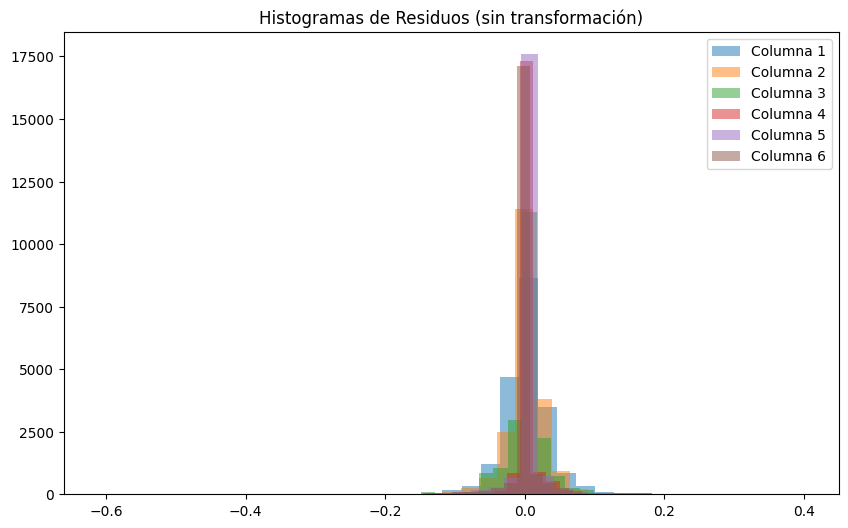

Ajustando GMM...
Dimensiones reducidas: 2, Varianza explicada: 0.9612


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1119: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Mejor modelo: {'gmm__covariance_type': 'spherical', 'gmm__reg_covar': 0.01}
Log-likelihood (train): -3.7073
Log-likelihood (test): -3.6355
Silhouette (train): 0.6047
Silhouette (test): 0.6095
Cluster 0 asignado como Desbalanceo
Cluster 1 asignado como Desalineación
P(Desbalanceo promedio): 0.879185
P(Desalineación promedio): 0.120815


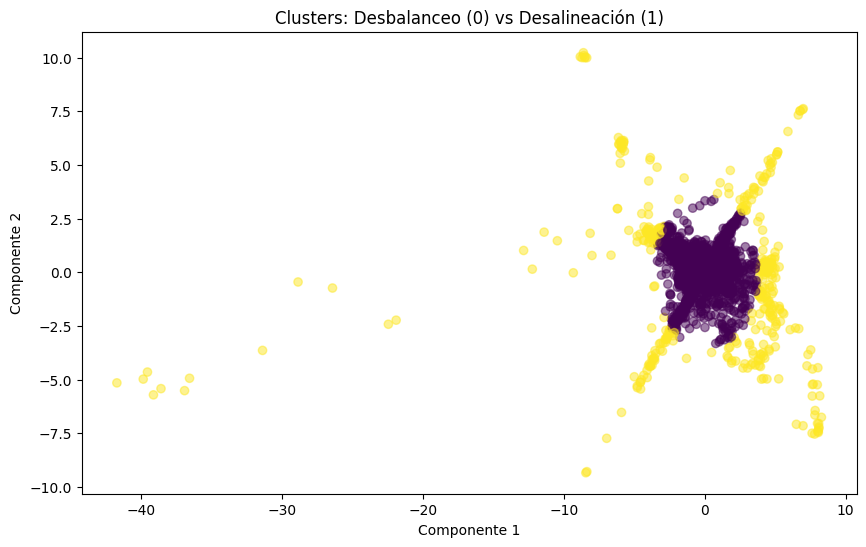


Analizando con transformación: log
Estadísticas de los residuos:
Media: [0.47614978 0.47623962 0.47630516 0.47642329 0.47649555 0.47648961]
Desv. Est.: [0.03087864 0.02763969 0.02457823 0.01935047 0.01425914 0.01469907]
Asimetría: [ -6.68368959  -7.70936378  -4.51708313 -12.22976034  -1.0661629
  -1.76034193]
Curtosis: [ 86.47143955 101.42758234  50.68088237 184.18166031  41.97888673
  30.01011981]
Columna 1 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 2 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 3 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 4 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 5 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 6 - Shapiro (p-valor): 0.0000 (No Gaussiana)


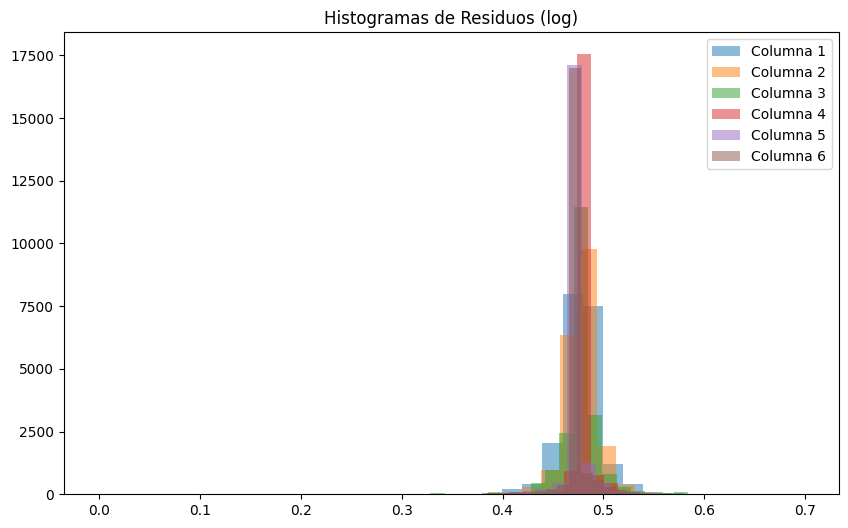

Ajustando GMM...
Dimensiones reducidas: 2, Varianza explicada: 0.9662


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1119: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Mejor modelo: {'gmm__covariance_type': 'spherical', 'gmm__reg_covar': 0.01}
Log-likelihood (train): -3.7387
Log-likelihood (test): -3.6694
Silhouette (train): 0.6755
Silhouette (test): 0.6757
Cluster 0 asignado como Desbalanceo
Cluster 1 asignado como Desalineación
P(Desbalanceo promedio): 0.919102
P(Desalineación promedio): 0.080898


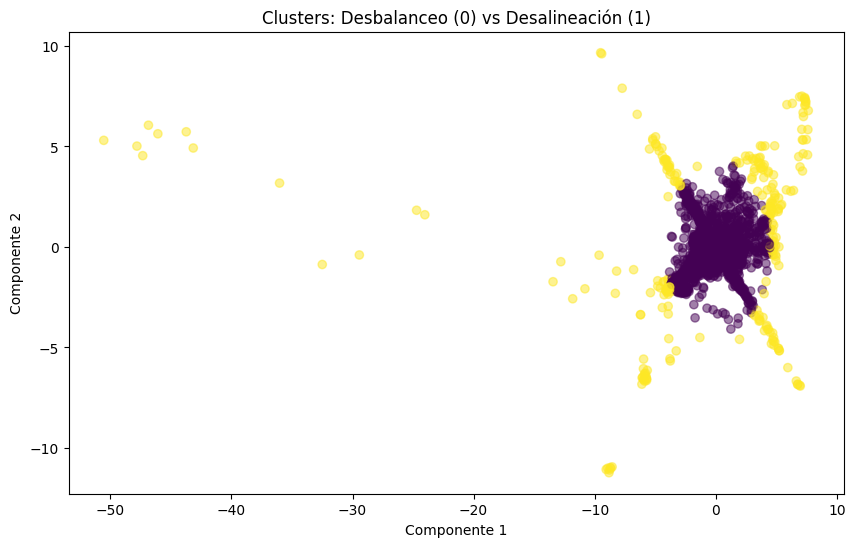


Analizando con transformación: boxcox
Estadísticas de los residuos:
Media: [-0.25279394 -0.23272035 -0.25592417 -0.15161323 -0.36113745 -0.31005195]
Desv. Est.: [0.01335802 0.00896848 0.01235508 0.00112978 0.01930943 0.01372119]
Asimetría: [0.55187302 0.85514838 0.84710837 1.3410518  0.72045629 0.78497651]
Curtosis: [ 8.63961484 14.7642712  13.9471044  20.71398322 46.04145237 33.76608975]
Columna 1 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 2 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 3 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 4 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 5 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 6 - Shapiro (p-valor): 0.0000 (No Gaussiana)


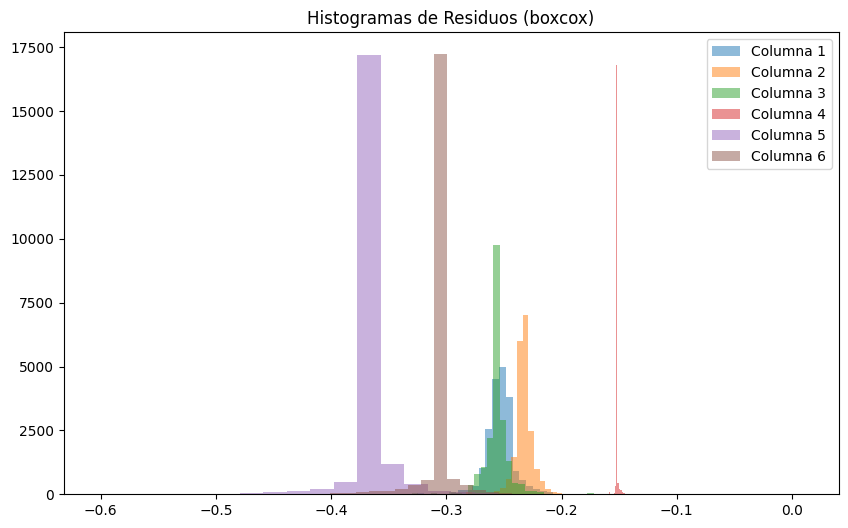

Ajustando GMM...
Dimensiones reducidas: 3, Varianza explicada: 0.9999


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1119: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Mejor modelo: {'gmm__covariance_type': 'spherical', 'gmm__reg_covar': 0.01}
Log-likelihood (train): -4.7687
Log-likelihood (test): -4.6810
Silhouette (train): 0.4365
Silhouette (test): 0.4493
Cluster 0 asignado como Desbalanceo
Cluster 1 asignado como Desalineación
P(Desbalanceo promedio): 0.757497
P(Desalineación promedio): 0.242503


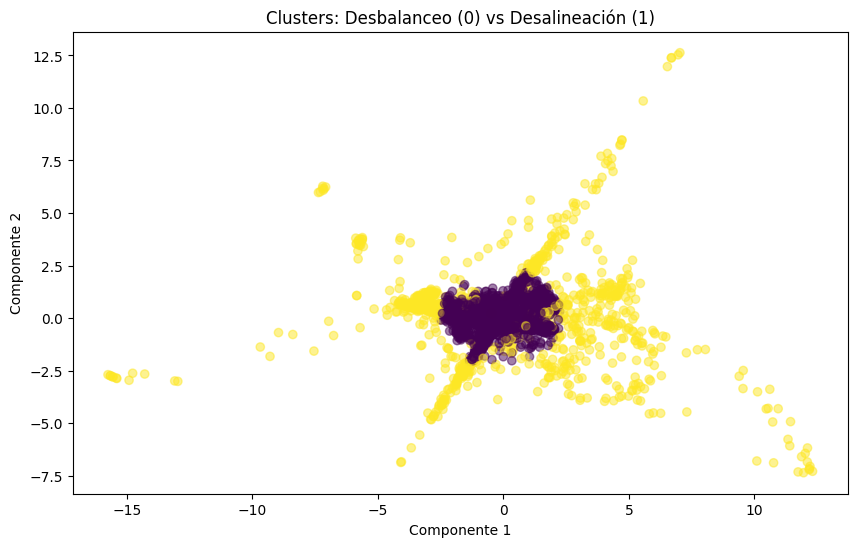

In [ ]:
for transform in [None, 'log', 'boxcox']:
        print(f"\nAnalizando con transformación: {transform or 'Ninguna'}")
        analyzer = ResidualsAnalyzer(fill_value=0.0, scaler_type='robust', n_components=2, transform=transform)
        analyzer.analyze_statistics(residuos)
        print("Ajustando GMM...")
        analyzer.fit(residuos)


Analizando con transformación: Ninguna
Estadísticas de los residuos:
Media: [ 3.42418488e-09 -7.58014275e-10  1.69587780e-09 -3.25808223e-10
  1.43757666e-08  3.39128028e-09]
Desv. Est.: [0.04544153 0.04046242 0.03766545 0.02786013 0.02284869 0.02341156]
Asimetría: [ -4.82487243  -5.97503657  -3.39409098 -11.1361128   -0.13409581
  -1.11447247]
Curtosis: [ 56.59385109  72.57866204  37.65713302 161.27732238  43.00546173
  29.22374212]
Columna 1 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 2 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 3 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 4 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 5 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 6 - Shapiro (p-valor): 0.0000 (No Gaussiana)


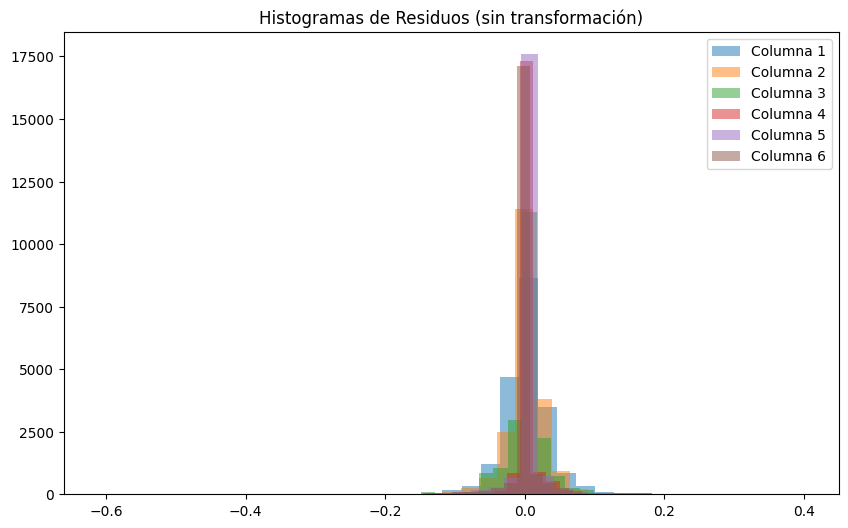

Ajustando GMM...
Dimensiones reducidas: 5, Varianza explicada: 0.9745


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1119: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Mejor modelo: {'gmm__covariance_type': 'spherical', 'gmm__reg_covar': 0.01}
Log-likelihood (train): 6.1397
Log-likelihood (test): 6.1734
Silhouette (train): 0.9129
Silhouette (test): 0.9200
Cluster 0 asignado como Desbalanceo
Cluster 1 asignado como Desalineación
P(Desbalanceo promedio): 0.996648
P(Desalineación promedio): 0.003352


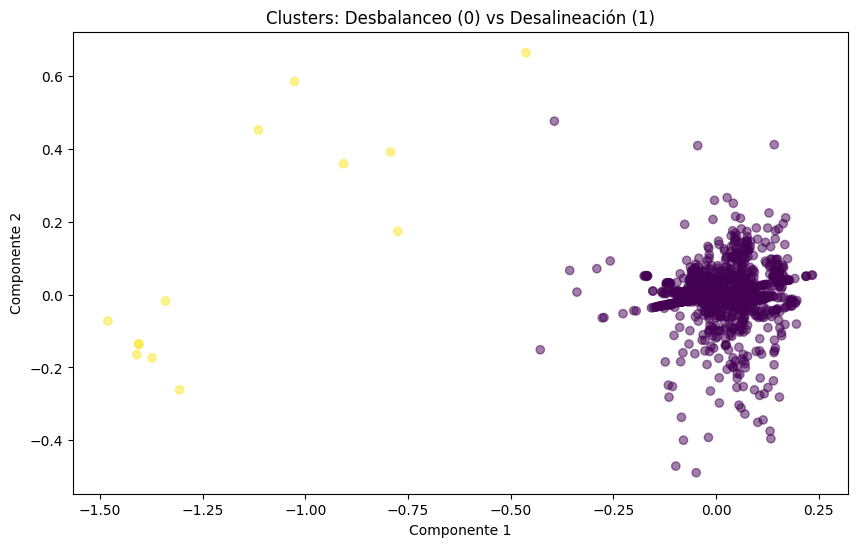


Analizando con transformación: log
Estadísticas de los residuos:
Media: [0.47614978 0.47623962 0.47630516 0.47642329 0.47649555 0.47648961]
Desv. Est.: [0.03087864 0.02763969 0.02457823 0.01935047 0.01425914 0.01469907]
Asimetría: [ -6.68368959  -7.70936378  -4.51708313 -12.22976034  -1.0661629
  -1.76034193]
Curtosis: [ 86.47143955 101.42758234  50.68088237 184.18166031  41.97888673
  30.01011981]
Columna 1 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 2 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 3 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 4 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 5 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 6 - Shapiro (p-valor): 0.0000 (No Gaussiana)


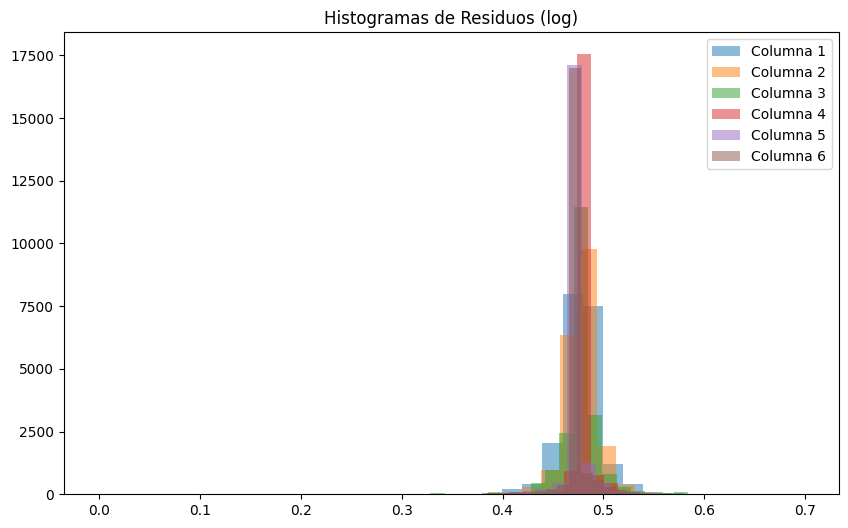

Ajustando GMM...
Dimensiones reducidas: 5, Varianza explicada: 0.9782


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1119: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Mejor modelo: {'gmm__covariance_type': 'spherical', 'gmm__reg_covar': 0.01}
Log-likelihood (train): 6.2338
Log-likelihood (test): 6.2664
Silhouette (train): 0.9220
Silhouette (test): 0.9286
Cluster 1 asignado como Desbalanceo
Cluster 0 asignado como Desalineación
P(Desbalanceo promedio): 0.996745
P(Desalineación promedio): 0.003255


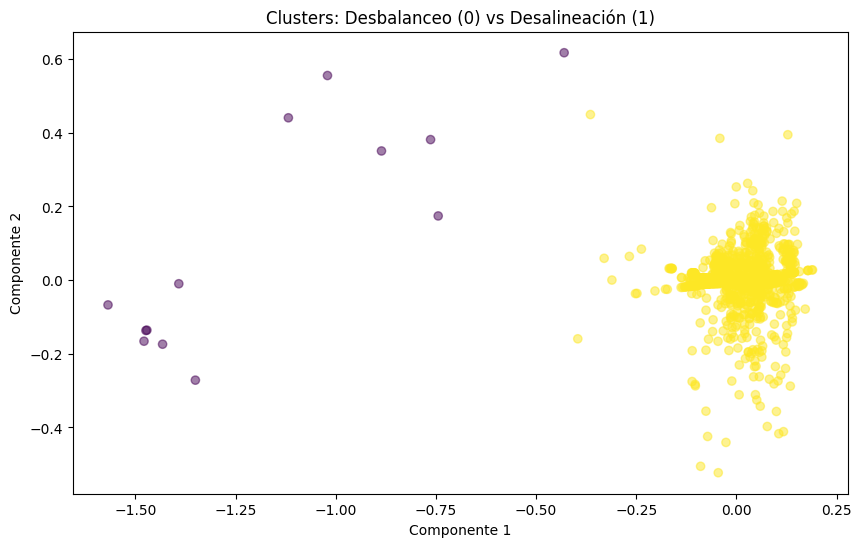


Analizando con transformación: boxcox
Estadísticas de los residuos:
Media: [-0.25279394 -0.23272035 -0.25592417 -0.15161323 -0.36113745 -0.31005195]
Desv. Est.: [0.01335802 0.00896848 0.01235508 0.00112978 0.01930943 0.01372119]
Asimetría: [0.55187302 0.85514838 0.84710837 1.3410518  0.72045629 0.78497651]
Curtosis: [ 8.63961484 14.7642712  13.9471044  20.71398322 46.04145237 33.76608975]
Columna 1 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 2 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 3 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 4 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 5 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 6 - Shapiro (p-valor): 0.0000 (No Gaussiana)


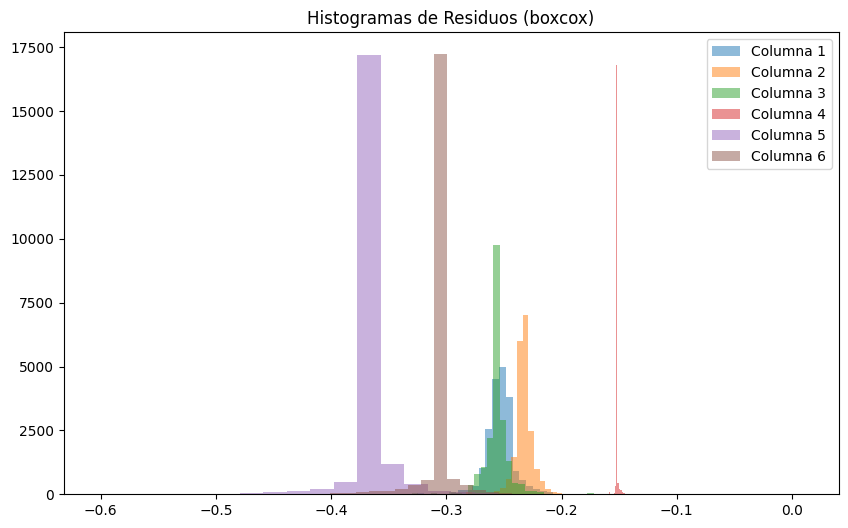

Ajustando GMM...
Dimensiones reducidas: 5, Varianza explicada: 0.9807


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1119: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Mejor modelo: {'gmm__covariance_type': 'spherical', 'gmm__reg_covar': 0.01}
Log-likelihood (train): 5.4380
Log-likelihood (test): 5.4915
Silhouette (train): 0.8021
Silhouette (test): 0.8215
Cluster 0 asignado como Desbalanceo
Cluster 1 asignado como Desalineación
P(Desbalanceo promedio): 0.996115
P(Desalineación promedio): 0.003885


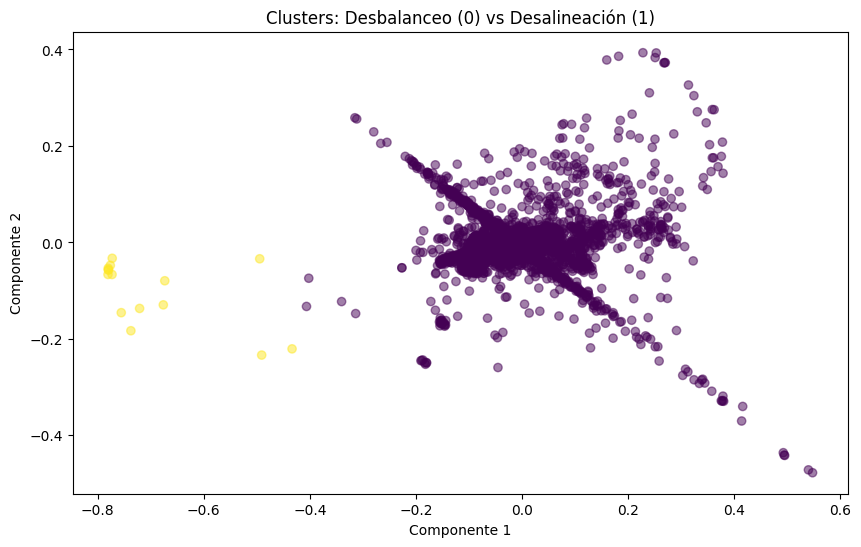

In [ ]:
for transform in [None, 'log', 'boxcox']:
        print(f"\nAnalizando con transformación: {transform or 'Ninguna'}")
        analyzer = ResidualsAnalyzer(fill_value=0.0, scaler_type='minmax', n_components=2, transform=transform)
        analyzer.analyze_statistics(residuos)
        print("Ajustando GMM...")
        analyzer.fit(residuos)

### Guardar el mejor modelo de acuerdo a los resultados obtenidos


Entrenando con transformación: log
Apilando múltiples archivos con rellenar_residuos...
Forma de residuos apilados: (20107, 6)
Estadísticas de los residuos:
Media: [0.47614978 0.47623962 0.47630516 0.47642329 0.47649555 0.47648961]
Desv. Est.: [0.03087864 0.02763969 0.02457823 0.01935047 0.01425914 0.01469907]
Asimetría: [ -6.68368959  -7.70936378  -4.51708313 -12.22976034  -1.0661629
  -1.76034193]
Curtosis: [ 86.47143955 101.42758234  50.68088237 184.18166031  41.97888673
  30.01011981]
Columna 1 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 2 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 3 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 4 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 5 - Shapiro (p-valor): 0.0000 (No Gaussiana)
Columna 6 - Shapiro (p-valor): 0.0000 (No Gaussiana)


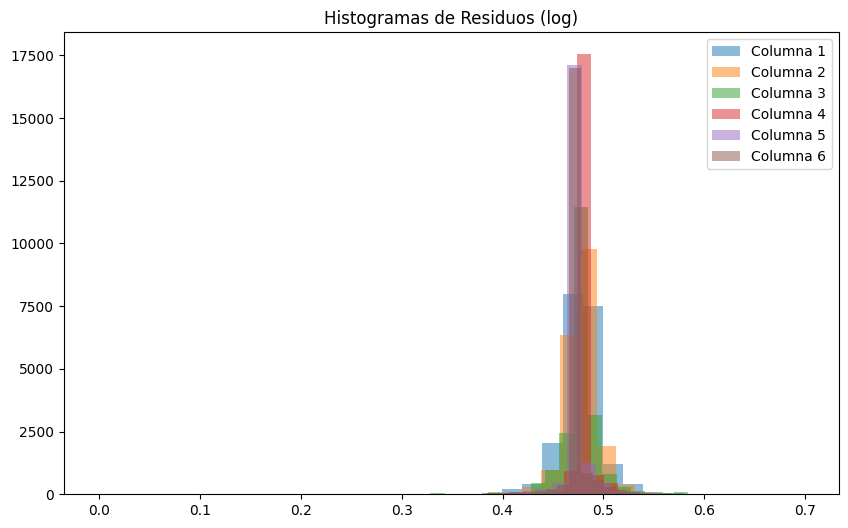

Ajustando GMM...
Apilando múltiples archivos para entrenamiento...
Forma de residuos igualados en fit: (20107, 6)
Dimensiones reducidas: 2, Varianza explicada: 0.9662


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1119: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Mejor modelo: {'gmm__covariance_type': 'spherical', 'gmm__reg_covar': 0.01}
Log-likelihood (train): -3.7387
Log-likelihood (test): -3.6694
Silhouette (train): 0.6755
Silhouette (test): 0.6757
Cluster 0 asignado como Desbalanceo
Cluster 1 asignado como Desalineación
P(Desbalanceo promedio): 0.919102
P(Desalineación promedio): 0.080898


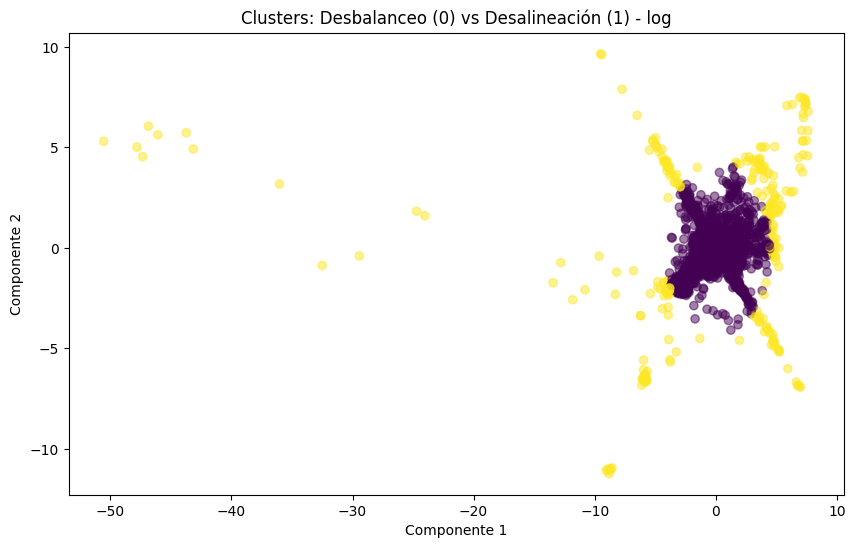

Modelo guardado en /content/drive/MyDrive/colab_notebooks/a-predictor-ia/gmm_model_log.pkl


In [ ]:
# Entrenar y guardar modelo con transformación 'log'
transform = 'log'
print(f"\nEntrenando con transformación: {transform}")
analyzer = ResidualsAnalyzer(fill_value=0.0, scaler_type='robust', n_components=2, transform=transform)
analyzer.analyze_statistics(residuos)
print("Ajustando GMM...")
analyzer.fit(residuos)
analyzer.save_model('/content/drive/MyDrive/colab_notebooks/a-predictor-ia/gmm_model_log.pkl')


In [ ]:
def graficar_ajuste_con_clusters(ruta_archivo, analyzer):
    # Procesar los datos
    processor = DataResidualsProcessor(degree=3, speed_col='KPH')
    processor.fit(ruta_archivo=ruta_archivo, is_preprocessed=True)
    residuos, columnas, kph, datos_originales, predicciones = processor.calculate_residuals()
    nombre_archivo = ruta_archivo.split('/')[-1]
    print(f"Forma de residuos generados: {residuos.shape}")
    print(f"Columnas: {columnas}")

    # Obtener predicciones del modelo
    labels, _ = analyzer.predict(residuos)  # Solo necesitamos las etiquetas

    # Ordenar por KPH de mayor a menor, asegurándonos de que kph_sorted sea 1D
    order = np.argsort(kph[:, 0])[::-1]
    kph_sorted = kph[:, 0][order]  # Extraer la primera columna y ordenar
    datos_sorted = datos_originales[order, :]
    predicciones_sorted = predicciones[order, :]
    labels_sorted = labels[order]

    # Crear figura con subgráficas
    plt.figure(figsize=(12, 6 * len(columnas)))
    for i, col in enumerate(columnas):
        plt.subplot(len(columnas), 1, i + 1)

        # Calcular la diferencia (residuos) para el sombreado
        diferencia = np.abs(datos_sorted[:, i] - predicciones_sorted[:, i])

        # Puntos coloreados por cluster
        scatter = plt.scatter(kph_sorted, datos_sorted[:, i], c=labels_sorted, cmap='viridis',
                             alpha=0.7, s=50, label=f"Datos reales ({col}) - Cluster")

        # Ajuste polinómico
        plt.plot(kph_sorted, predicciones_sorted[:, i], color='red',
                 label='Ajuste polinómico (grado 3)', linewidth=2)

        # Sombrear la diferencia entre datos reales y ajuste
        plt.fill_between(kph_sorted, predicciones_sorted[:, i], datos_sorted[:, i],
                        color='gray', alpha=0.3, label='Diferencia (ruido)')

        # Etiquetas y leyenda
        plt.xlabel('KPH (velocidad)')
        plt.ylabel(f'Amplitud ({col})')
        plt.title(f'{col} en {nombre_archivo}')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)

        # Ajustar límites para mejor visualización
        plt.ylim(min(datos_sorted[:, i].min(), predicciones_sorted[:, i].min()) * 1.1,
                 max(datos_sorted[:, i].max(), predicciones_sorted[:, i].max()) * 1.1)

    plt.tight_layout()
    plt.show()

### Predicciones

In [ ]:
imbalance_folder = "/content/drive/MyDrive/desbalanceo/tests"
file_paths = get_routes(imbalance_folder)
file_paths

['/content/drive/MyDrive/desbalanceo/tests/desbln_test.csv']

In [ ]:
file_paths[0]

'/content/drive/MyDrive/desbalanceo/tests/desbln_test.csv'

In [ ]:
# Archivo de entrenamiento
# new_file = '/content/drive/MyDrive/desbalanceo/normalize_data/otro_archivo.csv'
new_file = file_paths[5]
analyzer.load_model('/content/drive/MyDrive/colab_notebooks/a-predictor-ia/gmm_model_log.pkl')
processor.fit(ruta_archivo=new_file, is_preprocessed=True)
nuevos_residuos, nuevas_columnas, _, _, _ = processor.calculate_residuals()
print(f'Las nuevas columnas son: {nuevas_columnas}')
print(f'La forma de los residues es: {nuevos_residuos.shape}')

Modelo cargado desde /content/drive/MyDrive/colab_notebooks/a-predictor-ia/gmm_model_log.pkl
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/6_paradaDesblnCSPCSL.csv: ['Fecha', 'KPH', 'CSP', 'CSL', 'CIP', 'CIL', 'CTP', 'CTL']
Las nuevas columnas son: ['CSP', 'CSL']
La forma de los residues es: (1027, 2)


Forma de residuos en predict: (1027, 2)
Ajustando características: de 2 a 6
Forma ajustada de residuos: (1027, 6)

Predicciones para 6_paradaDesblnCSPCSL.csv:
Etiquetas (primeros 5): [1 1 1 1 1]
Probabilidades (primeros 5): [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
P(Desbalanceo promedio): 0.000000
P(Desalineación promedio): 1.000000
Columnas leídas desde /content/drive/MyDrive/desbalanceo/normalize_data/6_paradaDesblnCSPCSL.csv: ['Fecha', 'KPH', 'CSP', 'CSL', 'CIP', 'CIL', 'CTP', 'CTL']
Forma de residuos generados: (1027, 2)
Columnas: ['CSP', 'CSL']
Forma de residuos en predict: (1027, 2)
Ajustando características: de 2 a 6
Forma ajustada de residuos: (1027, 6)


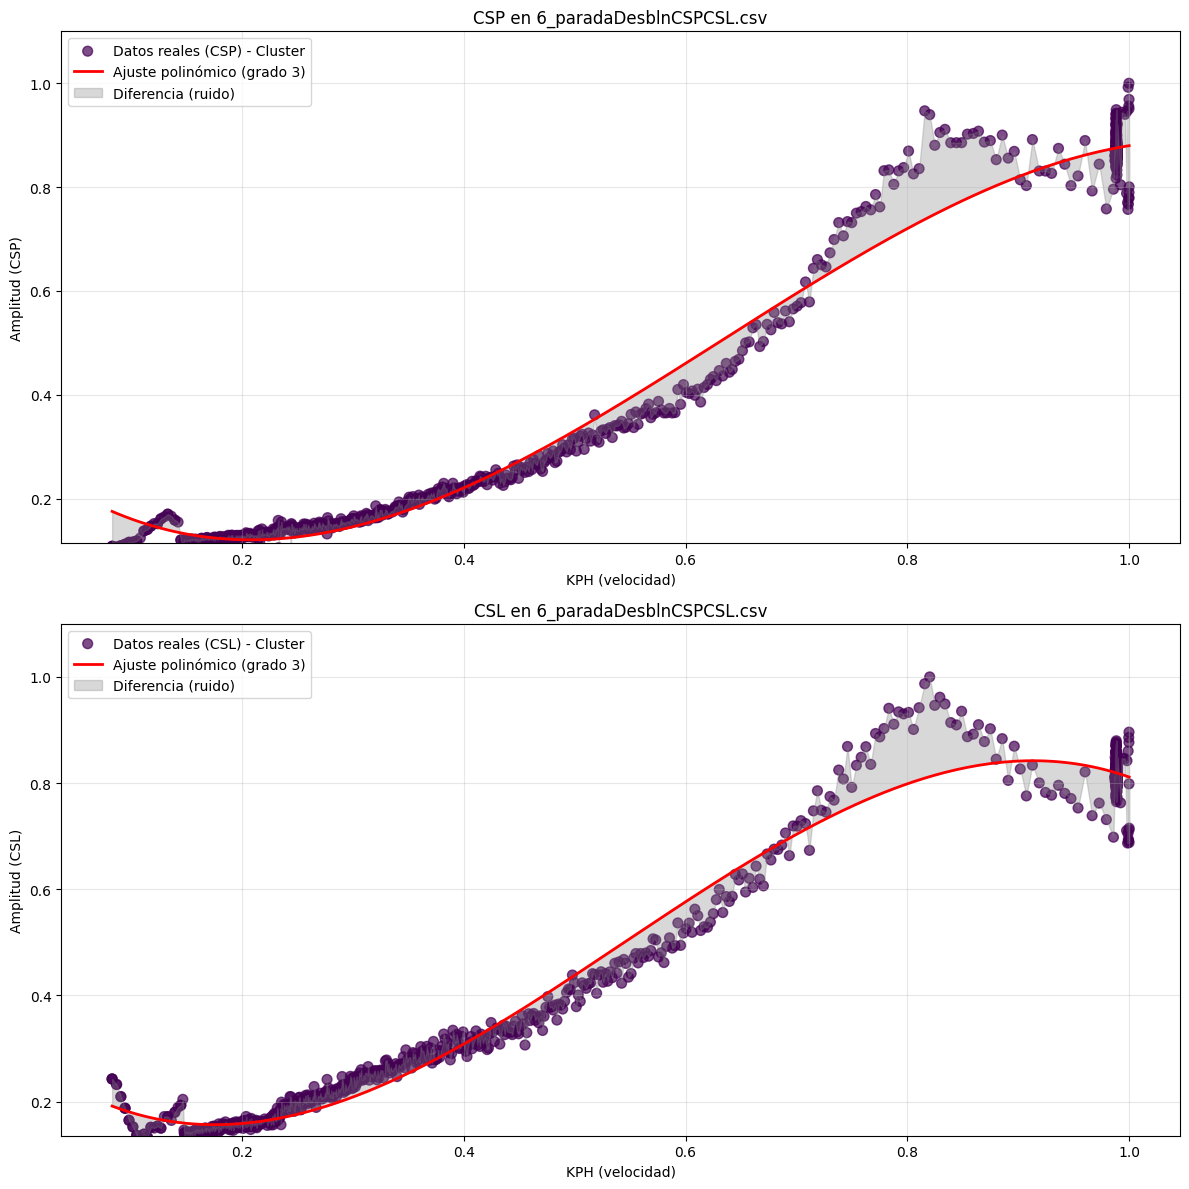

In [ ]:
labels, probs = analyzer.predict(nuevos_residuos)
print(f"\nPredicciones para {new_file.split('/')[-1]}:")
print(f"Etiquetas (primeros 5): {labels[:5]}")
print(f"Probabilidades (primeros 5): {probs[:5]}")
print(f"P(Desbalanceo promedio): {np.mean(probs[:, 0]):.6f}")
print(f"P(Desalineación promedio): {np.mean(probs[:, 1]):.6f}")

# Graficar
graficar_ajuste_con_clusters(new_file, analyzer)